<h2>Intro to Random Forest: Prediciting Blue Book for Bulldozers from Kaggle</h2>

Objective: The metric is, according to Kaggle, RMSLE (Root Mean Squared Log error) between the actual and predicted auction price. Therefore, we take the log of the price to make the predicition
    

In [153]:
# auto update notebok 
%load_ext autoreload
%autoreload 2

# show plot in notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from IPython.display import display

In [155]:
#? to see docs
#?? to see source code
# ??DataFrameSummary

In [156]:
PATH = "data/bulldozers/"

In [157]:
# Check path using python variable with {}
!ls {PATH}

Train.7z  Train.csv Train.zip


In [158]:
# setting low_memory = False allow pd to decide what the data types are
# {f'{PATH}Train.csv' Python 3.6 format string 
# parse 'saledate' as datatime object
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [159]:
# check num of rows
!wc -l data/bulldozers/Train.csv

  401126 data/bulldozers/Train.csv


In [160]:
# Display all data evenif it has a 1000 by 1000 df
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [161]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [162]:
# model = RandomForestRegressor(n_jobs= -1)
# # Target = df_raw.SalePrice
# # df_raw.drop('SalePrice', axis=1) returns everything, but target variable
# model.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

In [163]:
# RMSLE: the log of predicited price and the log of actual price. Square it and add them up. 
# The organizer cares about ratios instead of differences 

df_raw.SalePrice = np.log(df_raw.SalePrice)

In [164]:
df_raw.SalePrice.head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

<h2>Data preprocessing</h2>

**Random Forest**: a way of prediciting for both, categorical or numerical, or any kind of data
    - In general, it doesnt overfit, if it does, early stopping is an option
    - It doesn't need a separate validation set
    - It can tell how it generalizes, even for a single data point
    - It has few statistical assumptions, if any
    - It doesnt assume data is normally distributed, the relation is linear, interactions
    - It requires very few pices of feature engineering
 - It is a great place to start modeling

<h3>Dataset:</h3>
- It contains a mix of **continous** and **categorical** variables. Separate out these fields
- Extract useful features from date-time column 
- Date-time allows to capture any trend/cyclical behaviour as a function of time of any of there granuralities

**Numerical variables**
- Use `add_datepart()` converts a column of df from a datetime64 to many columns containing the information from the date
- Used for structured numeric data type

In [165]:
# Get year from saledate
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

**Categorical variables**

- The categorical variables are currently stored as strings, and doesn't proivde the numeric coding required for a random forest. 
- Use train_cats, fastai liberary,  to convert strings to pandas categories

In [166]:
# Example of cat columns
df_raw['UsageBand'].head()

0       Low
1       Low
2      High
3      High
4    Medium
Name: UsageBand, dtype: object

In [167]:
# Change any columns of strings in a panda's dataframe to a column of
# catagorical values. This applies the changes inplace.
# It stores an int for mapping to the cat field
train_cats(df_raw)

- `train_cats()` only keep the mapping for train data. To keep the mapping consistent between training and valida set, use `apply_cats` 

We can specify the order to use for categorical variables if we choose to

In [168]:
# since train_cats turn the data into categorical, we can 
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [169]:
# Reordering from ['High', 'Low', 'Medium'] to ['High', 'Medium', 'Low']
# In the model ['High', 'Medium', 'Low'] is equivalent to [0, 1, 2]
# The ordeting make split decision easier for RF
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered = True, inplace=True)
# Get mapping, for NaN mapping would be -1 
df_raw.UsageBand.cat.codes.head()

0    2
1    2
2    0
3    0
4    1
dtype: int8

In [170]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

<h3>Handling missing data</h3>

- We can't pass missing value directly to a random forest model


In [171]:
display_all(df_raw.isnull()    # return True(1) or False(0)
            .sum()    # sum
            .sort_index()    # get index
            /len(df_raw))    # normalize ny length

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [172]:
# Save intermediate data to ram 
os.makedirs('tmp', exist_ok=True)
# save it to disc in exactly the same format that in RAM -- fast read/write
df_raw.to_feather('tmp/raw')    

**`proc_df()`**
- Replace categories with their numeric codes
- Handle missing values: for numeric -- use median value and create new col for the replaced values
- For categorica pd handles it by setting NaNs to -1 and proc_df() will replace it with the int codes and add 1-- code for Nan is 0
- Split dependent variable into a separate col

In [173]:
df_raw = pd.read_feather('tmp/raw')

In [174]:
df, y, nans = proc_df(df_raw, 'SalePrice')

In [175]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [176]:
# Check if all data are numberic or boolean 
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,0,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


<h3>Base Model</h3> 

In [177]:
model = RandomForestRegressor(n_jobs=-1)     # split job for each cpu
model.fit(df, y)
print('Model R^2 of: ',model.score(df, y))

Model R^2 of:  0.9081614597522187


<h3>Validation set</h3>
- Helps diagnose over- and under-fitting problems

In [178]:
# Create validation set 
def split_vals(a, n):
    # valid set should replicate the time period of the test set, for time series data
    return a[:n].copy(), a[n:].copy()

n_valid = 12000    # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [179]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    if len(res)<= 4:
        print('rmse_train: {:2f}, rmse_valid: {:2f}, r^2_train: {:2f}, r^2_valid: {:2f} '.format(
        res[0], res[2], res[2], res[3]))
    else:
        print('rmse_train: {:2f}, rmse_valid: {:2f}, r^2_train: {:2f}, r^2_valid: {:2f}, oob_score: {:2f}'.format(
        res[0], res[2], res[2], res[3], res[4]))

In [180]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
# call print_score function
print_score(model)

CPU times: user 11.4 s, sys: 276 ms, total: 11.7 s
Wall time: 4.47 s
rmse_train: 0.210079, rmse_valid: 0.907764, r^2_train: 0.907764, r^2_valid: 0.873486 


Observation: The model has an R^2 of 0.98 on training and 0.89 on validation. Indicating that the model is overfitting badly. 

<h3>Speeding up model run time</h3>
- Take a subset of the data randomly and tune parameters

In [181]:
df_trn, y_trn, nans = proc_df(df_raw, 'SalePrice', subset=30000)
# split by dates
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [182]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
# call print_score function
print_score(model)

CPU times: user 3.01 s, sys: 31.2 ms, total: 3.05 s
Wall time: 1.08 s
rmse_train: 0.038509, rmse_valid: 0.996786, r^2_train: 0.996786, r^2_valid: 0.755716 


<h3>Build a Single Tree</h3>
Building a forest made of trees. In Scikitlearn
   - n_estimators: is the number of trees  
   - max_depth: is the depth of the tree
   - bootstrap: randomizer 

In [183]:
#  Create a deterministic tree
model = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.526603, rmse_valid: 0.399004, r^2_train: 0.399004, r^2_valid: 0.401396 


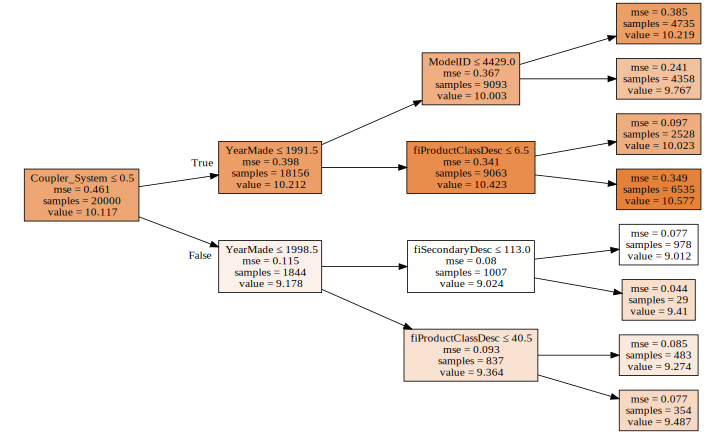

In [184]:
# draw tree
draw_tree(model.estimators_[0], df_trn, precision=3)

A tree consists of a sequence of binary decisions
- The first line indicates the split criteria
- At the root it has 20,000 samples
- `value` under the nodes indicates the average log of price

Building Random Forest from scratch follow the following steps
- Creare a tree based on first binary decision criteria
- Pick a variable and the value to split on
- For each variable, check if the split is better by taking `the weighted average of the two new nodes`, i.e, `mse_1*sample_1 ? mse_2*sample_2`
- Create as many models from trees by randomly selecting samples, that can make prediciton
- Errors of each randomly created models will be uncorrelated, and bagging of these tree based model will result a **Random Forest** model 
- **Bagging** is the process of combining different models. 
- **Ensembling** is the idea of averaging models

In [185]:
# Create a bigger tree, with max_depth unspecified
model = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.000000, rmse_valid: 1.000000, r^2_train: 1.000000, r^2_valid: 0.434150 


The training set looks great [r^2 = 1], but validation is bad. This is why we need to use `bagging` of multiple trees to get more generalizable results

<h3>Bagging</h3>
- It is a process of combining different models that are predicitive, but not correlated with each other. Resulting random errors, which has zero mean and what is left is `random forest`
- To create a Forest, we can use a statistical concept called bagging
- We can bag any kind of models to make it more robust

In [186]:
# create 10 tree based models, using defualt n_estimators=10, and combine them
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.037357, rmse_valid: 0.996976, r^2_train: 0.996976, r^2_valid: 0.786937 


Grab the predicitions for each individual tree

In [187]:
# estimators_ stores each tree's prediciton
# concatenate tree results on a new axis
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
# print('predicitions: ',preds )
# print first row predictions, one per tree
print('First row preds', preds[:,0])
print("Actual value {:2f} and mean of the 10 predicited {:2f}".format(np.mean(preds[:, 0]), y_valid[0]))

First row preds [9.30565 9.15905 9.4727  9.5819  9.61581 9.61581 9.43348 9.25913 9.43348 9.79813]
Actual value 9.467514 and mean of the 10 predicited 9.104980


In [188]:
# Predicition for each of the 10 trees
preds.shape

(10, 12000)

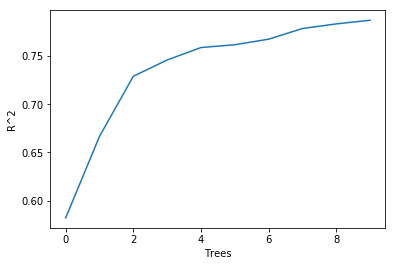

In [189]:
# Plot R^2 for each tree up to i
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);
plt.xlabel('Trees');
plt.ylabel('R^2');

The shape of this curve suggests that adding ore trees is not going to help much, since the curve is flattning. Compate it to the original model

In [190]:
model = RandomForestRegressor(n_estimators=20, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.030890, rmse_valid: 0.997932, r^2_train: 0.997932, r^2_valid: 0.789636 


**Hyper-parameter tuning: Number of trees**

R^2 on validation set for model with 10 trees is 076 and 20 trees is 0.77. Doubling trees didn't help. 

In [191]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.025937, rmse_valid: 0.998542, r^2_train: 0.998542, r^2_valid: 0.779290 


In [192]:
model = RandomForestRegressor(n_estimators=80, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.023364, rmse_valid: 0.998817, r^2_train: 0.998817, r^2_valid: 0.783485 


<h2>Out-of-bag (OOB) score</h2>

- Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both?

- Out-of-bag (OOB) error can give some insights about this and more. This is a typical feautre of RF/

- The idead is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This will tell whether the model is over-fitting, without needing a separate validation set. 

- It has also the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data and we want to avoid separating some out to create a validation set. 

- Using the rows that were not used for training in tree_i, we can use those rows as a validation set. The oob prediciton will be the average of each of the individual rows 

- This is as simple as adding one more parameters to our model constructor. 

In [193]:
# passing oob_score=True will create oob_erro in the score
model_oob = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
model_oob.fit(X_train, y_train)
print_score(model_oob)

rmse_train: 0.025449, rmse_valid: 0.998596, r^2_train: 0.998596, r^2_valid: 0.787826, oob_score: -6.576723


The oob_score is 0.85 close to validation r^2 (0.753). This shows that our validation set time difference is making an impact, as is model over-fitting.

<h2>Reducing over-fitting</h2>

<h3>Subsampling</h3>
 
 - The easiest way to avoid over-fitting is `subsampling`. And its also the best way to speed up analysis.  
 - This technique make any data size (big) managable to model it using RF

In [194]:
# Get the original dataset
df_trn, y_trn, nan = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is that rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. 

That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.


In [195]:
# oob_score and set_rf_samples are not compatible in the current version of fastai-- 
# the obb_score will be based on the bootstrap sample
# set oob_score = False to use set_rf_samples
# This is useful to run feature importance and partial dependence analysis, instead of running full dataset
set_rf_samples(200000)    # This is number of rows per tree

In [196]:
model_oob_full_data = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time model_oob_full_data.fit(X_train, y_train);
print_score(model_oob_full_data)

CPU times: user 36.5 s, sys: 897 ms, total: 37.4 s
Wall time: 15.2 s
rmse_train: 0.138216, rmse_valid: 0.960075, r^2_train: 0.960075, r^2_valid: 0.889455, oob_score: 0.870267


In [197]:
# Increase the number of trees
model_oob_full_data = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
model_oob_full_data.fit(X_train, y_train)
print_score(model_oob_full_data)

rmse_train: 0.126201, rmse_valid: 0.966714, r^2_train: 0.966714, r^2_valid: 0.899677, oob_score: 0.908421


<h3>Tree building parameters</h3>

Another way to reduce over-fitting is to grow trees less deep. This is done by specifiying `min_samples_leaf` that we require some minimum number of rows in every leaf node. This has two benefits:
- There are less decision rules for each leaf node, simpler models should generalize better.
- The predictions are made by averaging more rows in the leaf node, resulting less volatility

We will use a full bootstrap dample in order to show the impact of other over-fitting avoidance methods

In [198]:
# Reset to full dataset
reset_rf_samples()

In [199]:
# Get baseline model for the full dataset to compare it against the model with tuned params
model_base = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
model_base.fit(X_train, y_train)
print_score(model_base)

rmse_train: 0.078316, rmse_valid: 0.987181, r^2_train: 0.987181, r^2_valid: 0.897809, oob_score: 0.908470


oob_score is better than valdation set, this is because the validation set is from different time set, but oob_score is from the bootstraped

In [200]:
# Set min data at leaf to 3
# Common min_sample_leaf of values are 1, 3, 5, 10, 25
model_base = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
model_base.fit(X_train, y_train)
print_score(model_base)

rmse_train: 0.115034, rmse_valid: 0.972344, r^2_train: 0.972344, r^2_valid: 0.902019, oob_score: 0.908393


Validation r^2 is improved slightly from 0.9 to 0.902

We can also increase the amount of variation amongst the trees by not only use a subsample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

>Common values `max_features` are 1, 0.5, log2, sqrt. Defualt is use all of them (None)

In [201]:
model_base = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                                   n_jobs=-1, oob_score=True)
model_base.fit(X_train, y_train)
print_score(model_base)

rmse_train: 0.119272, rmse_valid: 0.970269, r^2_train: 0.970269, r^2_valid: 0.907126, oob_score: 0.911499


Validation r^2 is improved slightly from 0.902 to 0.906 and rmse is down from 0.235 from 0.223

<h2>Model Interpretation</h2>

<h3>Confidence based on tree variance</h3>

- It allows us to evaluate the confidence level of a specific observation (row). For example, for credit scoring to decide whether to give someone a lon or not, we need to see not only their level of risk, but also how confident we are. If they want to borrow lots of money and we are not at all confident about our ability to predicit whether they will pay back, we might want to give them a smaller loan.
- For model interpretation, there's no need to use the full dataset on each tree-- using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide muc variance across trees.
- The model averages predicitions across trees to get an estimate- but how can we know the confidence of the estimate?
    > One simple way is to use the standard deviation of predicitions, insteadof just using the mean. This will tell us the relative confidence of predicitions-- i.e., for rows where the trees give very different results, you would want to be more cautions of using those results., compared to cases where they are more consistent. 

In [202]:
# Reload data
df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [203]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [204]:
# reset_rf_samples()
set_rf_samples(50000)

In [205]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                             n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.206030, rmse_valid: 0.911285, r^2_train: 0.911285, r^2_valid: 0.888955, oob_score: 0.894189


In [206]:
%time preds = np.stack([t.predict(X_valid) for t in model.estimators_])
print('predicition for row # 1: {:2f} and the std {:2f}'.format(np.mean(preds[:, 0]), 
                                                          np.std(preds[:,0])))

CPU times: user 1.18 s, sys: 82.4 ms, total: 1.27 s
Wall time: 1.27 s
predicition for row # 1: 9.255989 and the std 0.231383


In [207]:
preds.shape

(40, 12000)

We need to loop trhrough each record to calculate sds, and runningi it in Python will be slow since it calculate each in series. We can use parallel processing from dastai to speed things up

In [208]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(model, get_preds))
print('predicition for row # 1: {:2f} and the std {:2f}'.format(np.mean(preds[:, 0]), 
                                                          np.std(preds[:,0])))

CPU times: user 75.8 ms, sys: 110 ms, total: 186 ms
Wall time: 655 ms
predicition for row # 1: 9.255989 and the std 0.231383


In [209]:
preds.shape

(40, 12000)

We can see that different trees are giving differernt estimates of this auction. In order to see how predicition confidence varies, we can add this into the dataset 

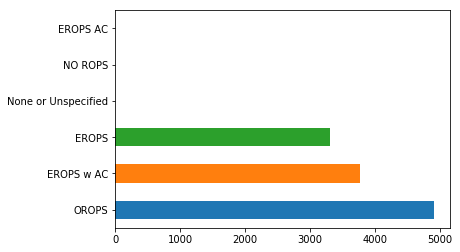

In [210]:
# Take a detail view of Enclosure
# Get a copy of the raw data
x = raw_valid.copy()
# Add std cols
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
# Plot hist 
x.Enclosure.value_counts().plot.barh();    # Enclosure is just a data field

In [211]:
# Group df by Enclosure and get avg
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_sum = x[flds].groupby('Enclosure', as_index = False).mean()
enc_sum

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838051,0.270368
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579083,0.262068
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683312,0.222730


Observations:
    - on average, prediction and the sale price are close to each other 
    - Standard deviation varies a little bit

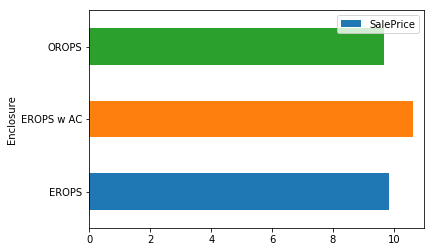

In [212]:
# Plot Enclosure
enc_sum = enc_sum[~pd.isnull(enc_sum.SalePrice)]
enc_sum.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

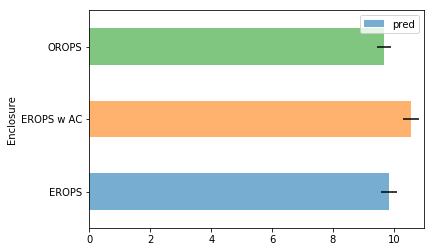

In [213]:
# Plot with std. This will tell us if there is some groups or some rows that we are not confident
enc_sum.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

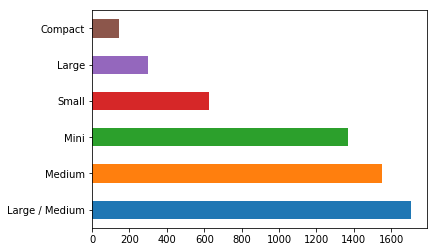

In [214]:
# Similar exercise for Product size
raw_valid.ProductSize.value_counts().plot.barh();

In [215]:
flds_prdSize = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds_prdSize].groupby(flds_prdSize[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.881837,0.362901
Large,10.470589,10.384496,0.356161
Large / Medium,10.691871,10.648910,0.292207
Medium,10.681511,10.623840,0.284284
Mini,9.535147,9.554849,0.240295
Small,10.324448,10.314615,0.313741


Observations:
    - when predicting var that is bigger, std would be higher 
    - sort by the ratio of std of predicitions to the predicitions themselves

In [216]:
pd.DataFrame((summ.pred_std/summ.pred).sort_values(ascending=False))

,0
ProductSize,
Compact,0.036724
Large,0.034297
Small,0.030417
Large / Medium,0.027440
Medium,0.026759
Mini,0.025149


Observations:
    - this tells us, for product size `Large` and `Compact`, our predicitions are less accurate
    - this is due to the fact that these are the smallest groups in the dataframe

## Feature importance
- It works by randoly shuffling each column, keeping the others as is.
- It's not normally enough to just know that a model can make accurate predicitions- we also want to know how it's maing the predicitions. 
- Feature importance will help us to see this

In [217]:
feature_importance = rf_feat_importance(model, df_trn); 
# Get top 10 important features
feature_importance[:10]

,cols,imp
5,YearMade,0.172010
37,Coupler_System,0.121330
13,ProductSize,0.093561
14,fiProductClassDesc,0.091379
2,ModelID,0.057737
63,saleElapsed,0.052821
38,Grouser_Tracks,0.041379
10,fiSecondaryDesc,0.041248
39,Hydraulics_Flow,0.040673
19,Enclosure,0.040020


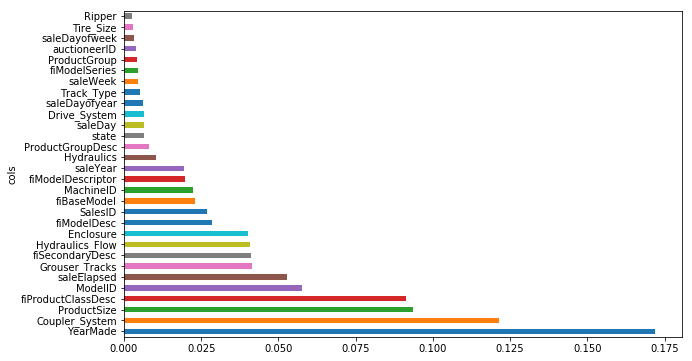

In [218]:
# Plot all of the feature impotance
def plot_feature_import(features):
    return features.plot.barh('cols', 'imp', figsize=(10, 6), legend=False)

plot_feature_import(feature_importance[:30]);

In [219]:
# Filter features where importance is > 0.005
to_keep = feature_importance[feature_importance.imp > 0.005].cols;
len(to_keep)

23

In [220]:
# Create train and valid df based on to_keep cols
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [221]:
# Re-run model using selected features
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                             n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

rmse_train: 0.207458, rmse_valid: 0.910051, r^2_train: 0.910051, r^2_valid: 0.892425, oob_score: 0.893686


The purpose of keeping important features is to save run time, it doesn't change much the result. This action also will remove colinearity, if any

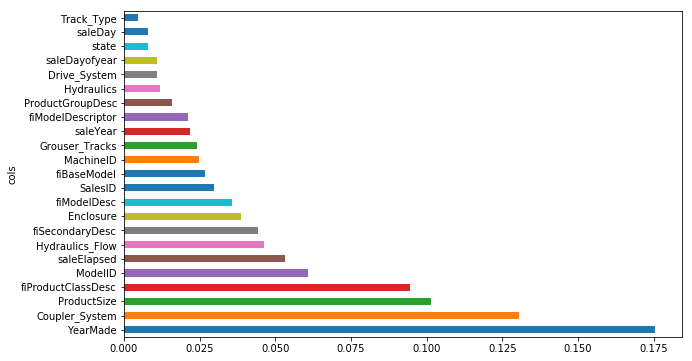

In [222]:
# Re-run fi with the to_keep columns
feature_importance = rf_feat_importance(model, df_keep)
plot_feature_import(feature_importance[:30]);

After cleaning the possible co-linearity, yearMade is now far from Couplerr_System. Couplerr_System become equally important to ProductSize and fiProductClassDesc. And the FI is much cleaner now.

## One-hot Encoding

- For at least interpreting model resul, we should always include pne-hot encoding
- `proc_df's` optional max_n_cat argument will turn some categorical variables into new columns.
- For example, the column ProductSize which has 6 categories:

>    
   - Large  
   - Large/ Medium
   - Medium 
   - Compact
   - Small
   - Mini

will get rurned into 6 new columns and the column **ProductSize** gets removed:
   
   >   
   - ProductSize_Large
   - ProductSize_Large / Medium
   - ProductSize_Medium
   - ProductSize_Compact
   - ProductSize_Small
   - ProductSize_Mini
 
- This transformation only happen to columns whose number of categories is no bigger than the value of the `max_n_cat` argument

In [223]:
# Pass max_n_cat to proc_df() for one-hot encoding
# If the cardinality, number of digits?, of a var is less than or equal to max_n_cat, it will get one=hot encoded
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

mdl = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                           max_features=0.6, n_jobs=-1, oob_score=True)
mdl.fit(X_train, y_train);


In [224]:
# Print scores
print_score(mdl)

rmse_train: 0.207199, rmse_valid: 0.910276, r^2_train: 0.910276, r^2_valid: 0.885237, oob_score: 0.892539


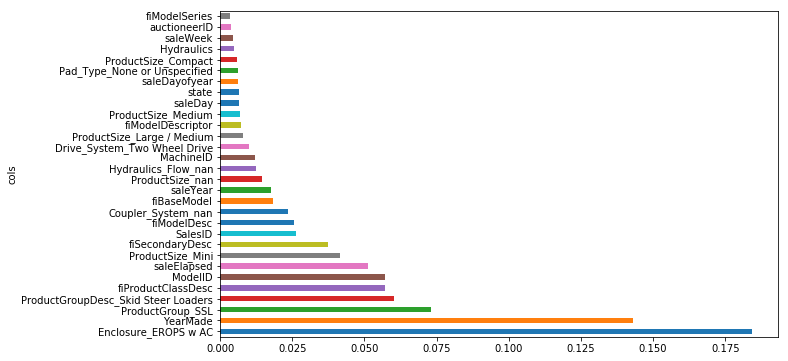

In [225]:
# Re-run fi with the to_keep columns with one-hot encoding
feature_importance = rf_feat_importance(mdl, df_trn2)
plot_feature_import(feature_importance[:30]);

Observation: Even if accuracy didnt change much becuse of the dummy encoding, now with one-hot encoding, Enclosure_EROPS w AC become the most important feature, 

## Removing redundant

- Redundant cariable with similar meaning makes model interpretation harder. Let remove them. 
- We can use hierarchuical ordering to see which columns have similar meaning in the rf model

In [226]:
# Import scipy to calculate rank colleratio matrix
from scipy.cluster import hierarchy as hc

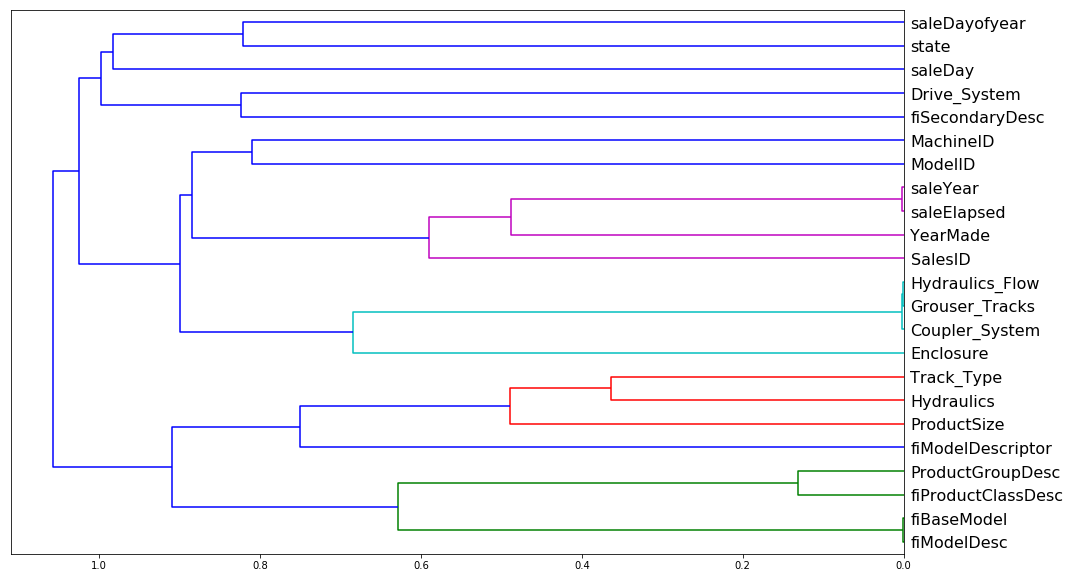

In [227]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

# Plot dendograms
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Features which meets at the right hand side have closer meaning. These are
['saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System']

In [228]:
# Run rf by removing redundent cols and see how the removal affects the r^2 or rmse of valid
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, 
                             n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [229]:
# Baseline model
get_oob(df_keep)

0.8897390715770356

In [230]:
# Remove redundent variable one at a time
for col in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print("obb_score after droping: ", col, get_oob(df_keep.drop(col, axis=1)))



obb_score after droping:  saleYear 0.8892596367984159
obb_score after droping:  saleElapsed 0.8867720671866366
obb_score after droping:  fiModelDesc 0.8883630729999417
obb_score after droping:  fiBaseModel 0.8893045239249446
obb_score after droping:  Grouser_Tracks 0.8894820346127447
obb_score after droping:  Coupler_System 0.8900813897556854


In [231]:
# We can remove one from each group
col_to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(col_to_drop, axis=1))

0.8880656659929902

Looking good! Similify the data with imaterial accuracy penality. Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [232]:
# Remove the col_to_drop from the df
df_keep.drop(col_to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [233]:
# save df
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [234]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

Re-train the model with the updated cols

In [235]:
# Train on all dataset
reset_rf_samples()

In [236]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

rmse_train: 0.125038, rmse_valid: 0.967325, r^2_train: 0.967325, r^2_valid: 0.909193, oob_score: 0.908750


## Partial dependence analysis
- It tells us how the important features relate to the dependent vriable behave on average
- For the var under consideration, keeping all other columns values as is,if we keep the var to have constant value and feed it to the model, how does it explain the target variable 
- It will give more richer information than a uni-variant plot

In [237]:
from pdpbox import pdp
from plotnine import *

In [238]:
# Get a sample of 50k data point
set_rf_samples(50000)

In [239]:
# Use the one-hot encoded categorical variables
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

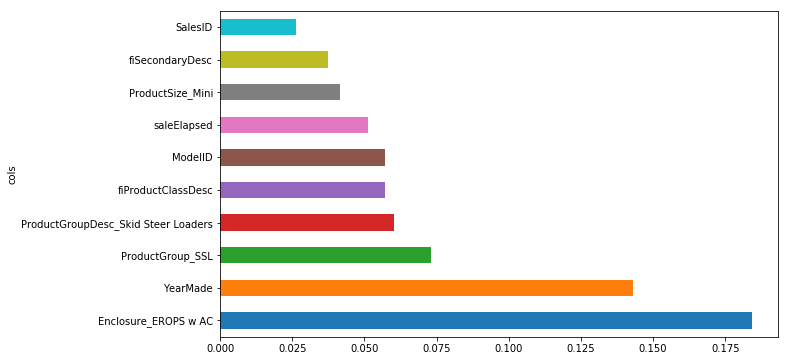

In [240]:
# Plot important features
plot_feature_import(rf_feat_importance(mdl, df_trn2)[:10]);

Let's learn more about the above 10 features. YearMade is the second most important feature. Lets plot YearMade against saleElapsed. 

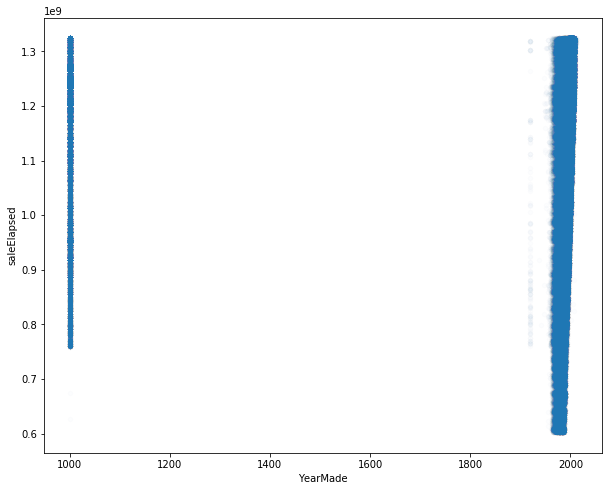

In [241]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

The graph shows that YearMade actually has a whole bunch of it is around 1000 yr-- this midght be indicating unknown year. Let's remove YearMade < 1930

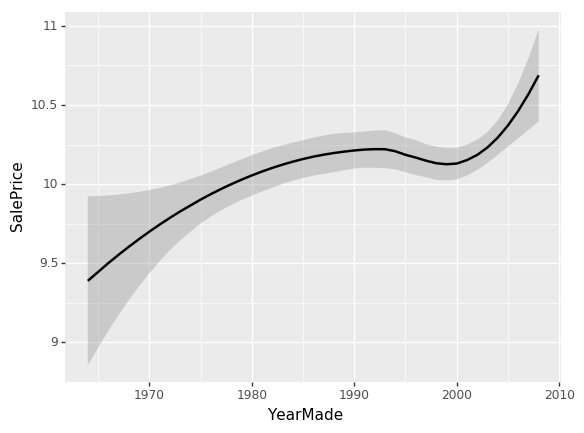

<ggplot: (-9223372036548061380)>

In [242]:
# Get 500 sample 
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)

# Univariant plot using ggplot
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, 
       method='loess')

We can see the the relationship between `YearMade` and `SalePrice` is all over the place and doesn't tell us much. There is a lot of collinearity going on, for example
- why the sale dropped for around year 2000

So we need to ask what is the relationship YearMade` and `SalePrice`, all other things being equall--  “All other things being equal” basically means if we sold something in 1990 vs. 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price? 
- we can use pdp to to anlyze the interaction of independet variales with 

In [243]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [244]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns.tolist(), feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

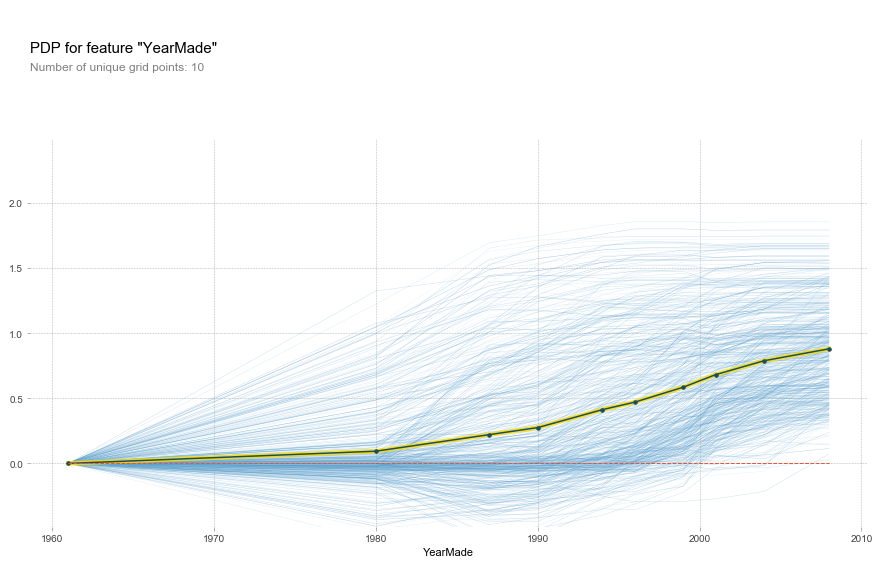

In [245]:
plot_pdp('YearMade');

Observation from pdp plot of `YearMade`
- The light blue lines are showing all 500 lines from the 500 predictions, for the subsample data points
- The dark line is the average. And it tells us how much would we have sold, on average,if we all of those products were actually made in 1985, 1990, 1993, etc. 
- Unlike the univariant plot, here we can see that for a period where we have reasonable amount of data, since 1990, its basically a straight line. 
- We would expect to see the relationship to be roughly linear and that is what we see from the pdp.


**Clusters**:
- Uses cluster analysis to look at each one of the 500 rows and check if those rows move in the 
same way. 
- Allows us to further investigate hidden patterns behinde those lines

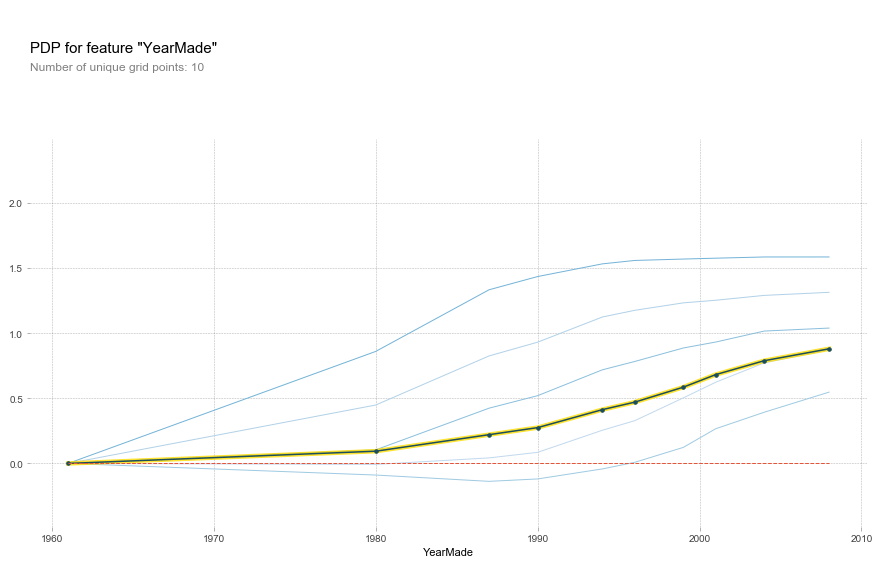

In [246]:
plot_pdp('YearMade', clusters=5);

The average remains the same, but we can see the five most common shapes. We can communicate that price of some kind of vehicle, after 1990,are pretty flat. Before that they were linear. This is something we could dig into. 

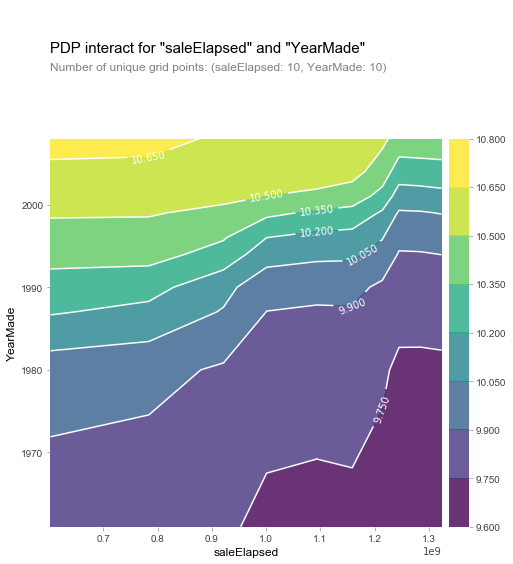

In [247]:
# 2D PDP
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(model=m, dataset=x, model_features=x.columns.tolist(), features=feats)
pdp.pdp_interact_plot(p, feats);

For one-hot-encoded variables, you can pass an array of them to plot_pdp and it will treat them as a category

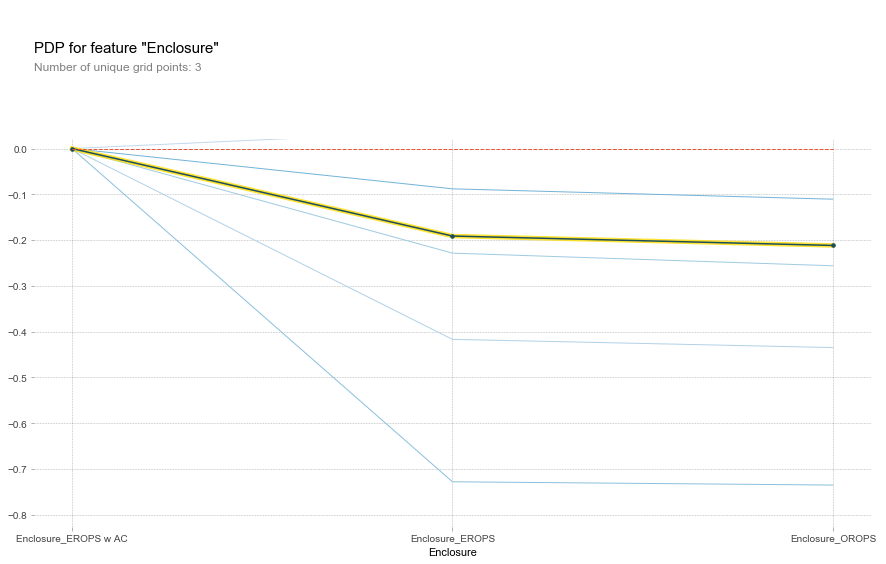

In [248]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure');

Observation: Enclosure w AC on average are more expensive than Enclosure_EROPS or Enclosure_OROPS

Based on the interaction let's set `age` to be equal to `saleYear-YearMade`. And run the rf model. 

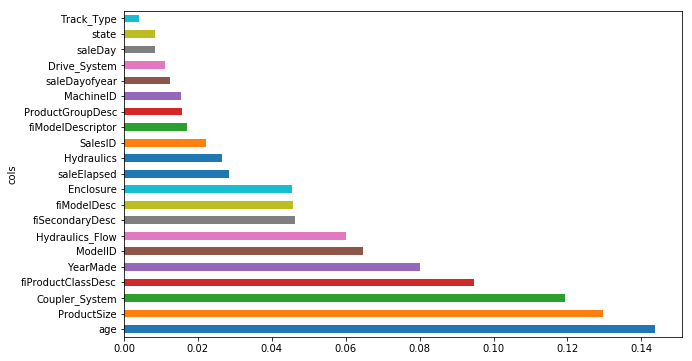

In [249]:
df_raw.YearMade[df_raw.YearMade < 1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_feature_import(rf_feat_importance(m, df_keep));

## Tree interpreter
- Here is the idea. Let’s say you are an insurance company and somebody rings up and you give them a quote and they say “oh, that’s $500 more than last year. Why?” So in general, you’ve made a prediction from some model and somebody asks why. This is where we use this method called tree interpreter. What tree interpreter does is it allows us to take a particular row.

In [250]:
from treeinterpreter import treeinterpreter as ti

In [251]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)
# Pick the first row
row = X_valid.values[None, 0];
row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,    2300944,          0,         12,          4,         35,
                16,          0,        259,          2,         11]])

We can pass in rf model and row of data to `ti.predict`. And it will give us three things 
- `prediction:` The predicition from rf
- `bias`: The average sale price across the whole original dataset
- `contributions`: A column and the value to split by, i.e., the predictor, and how much it changed the predicited value

In [252]:
predicition, bias, contribution = ti.predict(m, row)

In [253]:
predicition[0], bias[0]

(9.402360150917469, 10.10547345682156)

Here are all of our predicitors and the value of each

In [254]:
idxs = np.argsort(contribution[0])

[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contribution[0][idxs])]

[('ProductSize', 'Mini', -0.5306743183929754),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.14188698563193372),
 ('age', 11, -0.10684766451286287),
 ('fiModelDesc', 'KX1212', -0.0992750815397911),
 ('Enclosure', 'EROPS', -0.03948228282633237),
 ('fiSecondaryDesc', nan, -0.033583079246714796),
 ('fiModelDescriptor', nan, -0.023989906247637683),
 ('saleDayofyear', 259, -0.022667539581701757),
 ('MachineID', 2300944, -0.003566044783561084),
 ('saleDay', 16, -0.0023982514466003744),
 ('Drive_System', nan, 0.0027540255633855095),
 ('saleElapsed', 1284595200, 0.00415852055175221),
 ('state', 'Ohio', 0.006539406396917036),
 ('SalesID', 4364751, 0.007826896888519563),
 ('ProductGroupDesc', 'Track Excavators', 0.010619079358257589),
 ('Hydraulics', 'Standard', 0.02424770476645106),
 ('Hydraulics_Flow', nan, 0.026312004766953657),
 ('Track_Type', 'Steel', 0.02829587727226861),
 ('Coupler_System', nan, 0.052897810809151256),
 ('YearMade', 1999, 0.066896112

In [255]:
# Sum con and add them to bias to get the final prediction
contribution[0].sum()

-0.7031133059040915

## Extrapolation
- Rf gives us the average predicition over all the training set and when the data has temporal component, extrapolating to price of the future would be unreliable since the data could be old
- Extrapolation is easy for linear models, but a rando forest can't
- One strategy to overercome this is removing time dependent column from the datset. This will help model generalize better

Step 1: Figure out difference beteen training and valudation set. This will help us identify predictors which has a strong temporal component. This component will be irrelevant by the time we get to the future time period.

In [256]:
# Create a new column to which identiffies wheather validation set in in the taining or not
#  This new column would be a targt variable 
df_ext = df_keep.copy()    # train and valid together 
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0    # set is_valid to 0 for train
# Treat is_valid as a target var and run rf 
x, y, nas = proc_df(df_ext, 'is_valid')

This is a great trick in Kaggle because they often won’t tell you whether the test set is a random sample or not. So you could put the test set and training set together, create a new column called is_test and see if you can predict it. If you can, you don’t have a random sample which means you have to figure out how to create a validation set from it

This is a random forest not to predict price but predict if data point is in the validation set or not

In [257]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

The result shows that the validation set is not random, because we can predict it with 0.9999 oob_score.

Looking at the feature importance, we can see that `SaleID` is not random. `saleElaosed` is the number of days since the first dat in the dataset and its a good predictor. `MachineID` is also being labeled with some consective identifiers 

In [258]:
fi = rf_feat_importance(m, x); 
fi[:10]

,cols,imp
10,SalesID,0.835128
5,saleElapsed,0.127651
11,MachineID,0.029150
18,saleDayofyear,0.001566
0,YearMade,0.001468
4,ModelID,0.001227
13,Hydraulics,0.000891
9,fiModelDesc,0.000807
1,Coupler_System,0.000558
19,Track_Type,0.000369


Lets see the value of the top 3 cols and see their actual value in the train and valid dataset

In [259]:
feats = ['SalesID', 'saleElapsed', 'MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [260]:
feats = ['SalesID', 'saleElapsed', 'MachineID']
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


We can see that, for example, `SalesID` on average is 1.8 mil in the training set, white it is 5.8 mil in the validation set. Implying that they are indeed very different.

In [261]:
# Let's drop them 
x.drop(feats, axis=1, inplace=True)

m = m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789093175444064

Revisit feature imporance of the update model

In [262]:
fi = rf_feat_importance(m, x); 
fi[:10]

,cols,imp
17,age,0.228364
0,YearMade,0.192270
15,saleDayofyear,0.158079
4,ModelID,0.079828
8,fiModelDesc,0.063497
13,saleDay,0.059016
12,state,0.055932
3,fiProductClassDesc,0.034575
5,fiSecondaryDesc,0.025730
7,Enclosure,0.021012


`age`, `YearMade`, and `saleDayofyear` are the top 3 predictors. Lets remove them from the model and re-run rf again

In [263]:
# reset data and get the model with fresh data
set_rf_samples(50000)

In [264]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

rmse_train: 0.208597, rmse_valid: 0.909061, r^2_train: 0.909061, r^2_valid: 0.889238, oob_score: 0.892474


Loop over each each feature and see how removing each feature chenge the regressor preformance

In [265]:
feats = ['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
rmse_train: 0.209338, rmse_valid: 0.908414, r^2_train: 0.908414, r^2_valid: 0.890500, oob_score: 0.892104
saleElapsed
rmse_train: 0.213935, rmse_valid: 0.904347, r^2_train: 0.904347, r^2_valid: 0.884805, oob_score: 0.887207
MachineID
rmse_train: 0.207169, rmse_valid: 0.910302, r^2_train: 0.910302, r^2_valid: 0.892178, oob_score: 0.894446
age
rmse_train: 0.208795, rmse_valid: 0.908888, r^2_train: 0.908888, r^2_valid: 0.889996, oob_score: 0.892289
YearMade
rmse_train: 0.208785, rmse_valid: 0.908897, r^2_train: 0.908897, r^2_valid: 0.887495, oob_score: 0.892336
saleDayofyear
rmse_train: 0.208258, rmse_valid: 0.909356, r^2_train: 0.909356, r^2_valid: 0.893319, oob_score: 0.893273


In [266]:
# Reset sample
reset_rf_samples()

In [267]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

rmse_train: 0.138088, rmse_valid: 0.960148, r^2_train: 0.960148, r^2_valid: 0.915460, oob_score: 0.908857


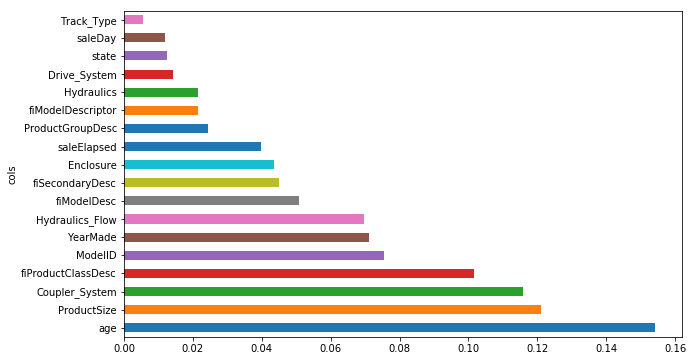

In [268]:
# Get feature importance with updated features
plot_feature_import(rf_feat_importance(m, X_train));

In [269]:
# save model
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Final Model

In [270]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 3s, sys: 8.79 s, total: 3min 12s
Wall time: 1min 4s
rmse_train: 0.080381, rmse_valid: 0.986497, r^2_train: 0.986497, r^2_valid: 0.920473, oob_score: 0.914354


*Disclaimer: This notebook is based on fastai Machine Learning online course and all the credit goes to Geremy* 